# 04 — Brick Discretization: From Smooth Surface to Discrete Assembly

The FDM solver (notebook 01) gives us a smooth vault surface. But a real masonry vault isn't smooth — it's an assembly of individual bricks held together by compression.

This notebook converts the smooth surface into discrete bricks. Each quad face in the mesh becomes a volumetric brick, extruded inward along the surface normal. The result is a `BrickAssembly` — a data structure that knows every brick's position, orientation, and neighbors.

In [1]:
from compas.datastructures import Mesh
from compas_fd.solvers import fd_numpy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from vault_designer.voxelize import voxelize, brick_faces
from vault_designer.visualize import plot_vault, plot_bricks

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## Step 1: Rebuild the Vault

Quick recap from notebook 01 — create a 10×10 mesh and solve with FDM.

In [2]:
# Create mesh and solve
mesh = Mesh.from_meshgrid(dx=10.0, nx=10)
vertices = mesh.vertices_attributes('xyz')
edges = list(mesh.edges())
fixed = list(mesh.vertices_on_boundary())
loads = [[0.0, 0.0, -1.0] for _ in vertices]
forcedensities = [1.0] * len(edges)

result = fd_numpy(
    vertices=vertices, fixed=fixed, edges=edges,
    forcedensities=forcedensities, loads=loads,
)

vault_xyz = result.vertices.copy()
vault_xyz[:, 2] = -vault_xyz[:, 2]

print(f"Vertices: {mesh.number_of_vertices()}")
print(f"Faces:    {mesh.number_of_faces()}")
print(f"Peak height: {vault_xyz[:, 2].max():.2f} m")

Vertices: 121
Faces:    100
Peak height: 7.31 m


## Step 2: Voxelize — Surface to Bricks

One function call converts the smooth surface into discrete bricks. Each mesh face becomes a brick with 0.2m thickness.

In [3]:
assembly = voxelize(vault_xyz, mesh, thickness=0.2)

print(f"Brick count:  {len(assembly)}")
print(f"Face count:   {mesh.number_of_faces()}")
print(f"Match:        {len(assembly) == mesh.number_of_faces()}")
print(f"Thickness:    {assembly.thickness} m")
print(f"Centers shape: {assembly.centers.shape}")
print(f"Corners shape: {assembly.corners.shape}")
print(f"Normals shape: {assembly.normals.shape}")

Brick count:  100
Face count:   100
Match:        True
Thickness:    0.2 m
Centers shape: (100, 3)
Corners shape: (100, 8, 3)
Normals shape: (100, 3)


## Step 3: Render the Bricks

Side-by-side: smooth vault surface vs. discrete brick assembly.

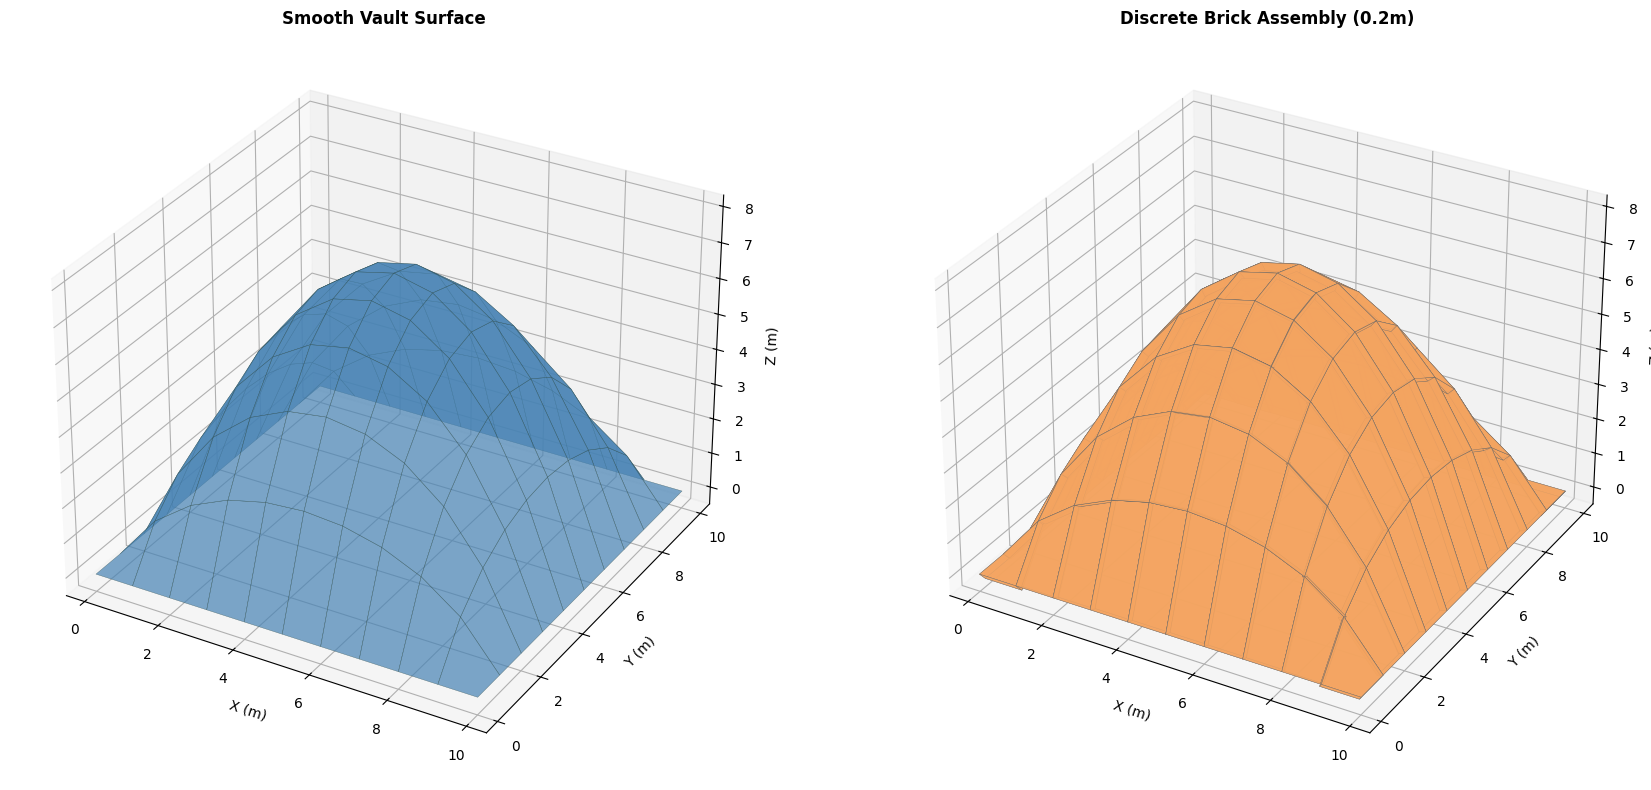

In [4]:
fig = plt.figure(figsize=(18, 8))

# Smooth surface
ax1 = fig.add_subplot(121, projection='3d')
face_verts = [[vault_xyz[v] for v in mesh.face_vertices(f)] for f in mesh.faces()]
poly = Poly3DCollection(face_verts, alpha=0.7, facecolor='steelblue',
                        edgecolor='darkslategray', linewidth=0.3)
ax1.add_collection3d(poly)
ax1.set_xlim(-0.5, 10.5); ax1.set_ylim(-0.5, 10.5)
ax1.set_zlim(-0.5, vault_xyz[:, 2].max() + 1)
ax1.set_title('Smooth Vault Surface', fontweight='bold')
ax1.set_xlabel('X (m)'); ax1.set_ylabel('Y (m)'); ax1.set_zlabel('Z (m)')
ax1.view_init(elev=30, azim=-60)

# Brick assembly
ax2 = fig.add_subplot(122, projection='3d')
all_polys = []
for i in range(len(assembly)):
    for f in brick_faces(assembly.corners[i]):
        all_polys.append(f)
brick_poly = Poly3DCollection(all_polys, alpha=0.85, facecolor='sandybrown',
                              edgecolor='dimgray', linewidth=0.3)
ax2.add_collection3d(brick_poly)
ax2.set_xlim(-0.5, 10.5); ax2.set_ylim(-0.5, 10.5)
ax2.set_zlim(-0.5, vault_xyz[:, 2].max() + 1)
ax2.set_title('Discrete Brick Assembly (0.2m)', fontweight='bold')
ax2.set_xlabel('X (m)'); ax2.set_ylabel('Y (m)'); ax2.set_zlabel('Z (m)')
ax2.view_init(elev=30, azim=-60)

plt.tight_layout()
plt.show()

## Step 4: Inspect a Single Brick

Let's look at one brick in detail — its corners, normal, and neighbors.

In [5]:
# Pick a brick near the center of the vault
center_dists = np.linalg.norm(assembly.centers[:, :2] - [5.0, 5.0], axis=1)
brick_idx = int(np.argmin(center_dists))

print(f"Brick index: {brick_idx}")
print(f"Center:  {assembly.centers[brick_idx].round(3)}")
print(f"Normal:  {assembly.normals[brick_idx].round(3)}")
print(f"Normal magnitude: {np.linalg.norm(assembly.normals[brick_idx]):.6f}")
print(f"Neighbors: {assembly.neighbors[brick_idx]}")
print(f"Mesh face vertices: {assembly.face_vertices[brick_idx]}")
print()
print("Outer face corners (0-3):")
for j in range(4):
    print(f"  [{j}] {assembly.corners[brick_idx, j].round(3)}")
print("Inner face corners (4-7):")
for j in range(4, 8):
    print(f"  [{j}] {assembly.corners[brick_idx, j].round(3)}")

# Verify inner face is exactly `thickness` away from outer face
diffs = np.linalg.norm(
    assembly.corners[brick_idx, :4] - assembly.corners[brick_idx, 4:8], axis=1
)
print(f"\nOuter-to-inner distances: {diffs.round(4)}")
print(f"All exactly {assembly.thickness}m? {np.allclose(diffs, assembly.thickness)}")

Brick index: 45
Center:  [4.523 5.477 6.968]
Normal:  [-0.231  0.231  0.945]
Normal magnitude: 1.000000
Neighbors: [44, 55, 46, 35]
Mesh face vertices: [49, 60, 61, 50]

Outer face corners (0-3):
  [0] [4.   5.   7.06]
  [1] [5.   5.   7.31]
  [2] [5.   6.   7.06]
  [3] [4.    6.    6.821]
Inner face corners (4-7):
  [4] [4.046 4.954 6.871]
  [5] [5.046 4.954 7.121]
  [6] [5.046 5.954 6.871]
  [7] [4.046 5.954 6.632]

Outer-to-inner distances: [0.2 0.2 0.2 0.2]
All exactly 0.2m? True


## Step 5: Neighbor Graph

Visualize the adjacency structure: nodes at brick centers, edges between neighbors.

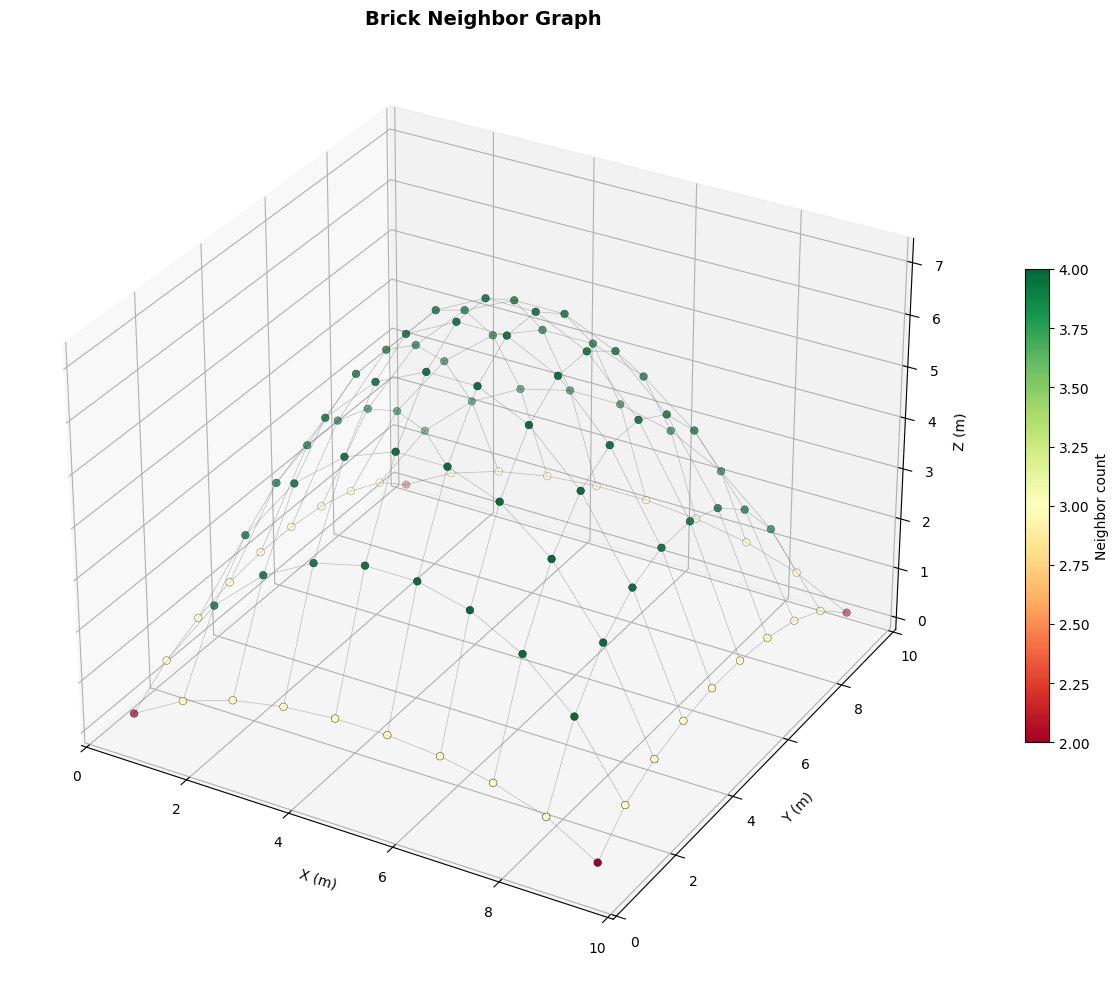

Neighbor relationships symmetric: True
Neighbor counts — min: 2, max: 4, mean: 3.6


In [6]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Draw edges between neighboring bricks
for i, nbs in enumerate(assembly.neighbors):
    for j in nbs:
        if j > i:  # draw each edge once
            pts = np.array([assembly.centers[i], assembly.centers[j]])
            ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], 'gray', linewidth=0.5, alpha=0.5)

# Draw nodes colored by neighbor count
n_neighbors = np.array([len(nb) for nb in assembly.neighbors])
sc = ax.scatter(
    assembly.centers[:, 0], assembly.centers[:, 1], assembly.centers[:, 2],
    c=n_neighbors, cmap='RdYlGn', s=30, edgecolors='black', linewidth=0.3,
)
plt.colorbar(sc, ax=ax, shrink=0.5, label='Neighbor count')

ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
ax.set_title('Brick Neighbor Graph', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=-60)
plt.tight_layout()
plt.show()

# Verify symmetry
symmetric = all(
    i in assembly.neighbors[j]
    for i, nbs in enumerate(assembly.neighbors)
    for j in nbs
)
print(f"Neighbor relationships symmetric: {symmetric}")
print(f"Neighbor counts — min: {n_neighbors.min()}, max: {n_neighbors.max()}, mean: {n_neighbors.mean():.1f}")

## Step 6: Color by Height

Using `plot_bricks()` with height-mapped coloring.

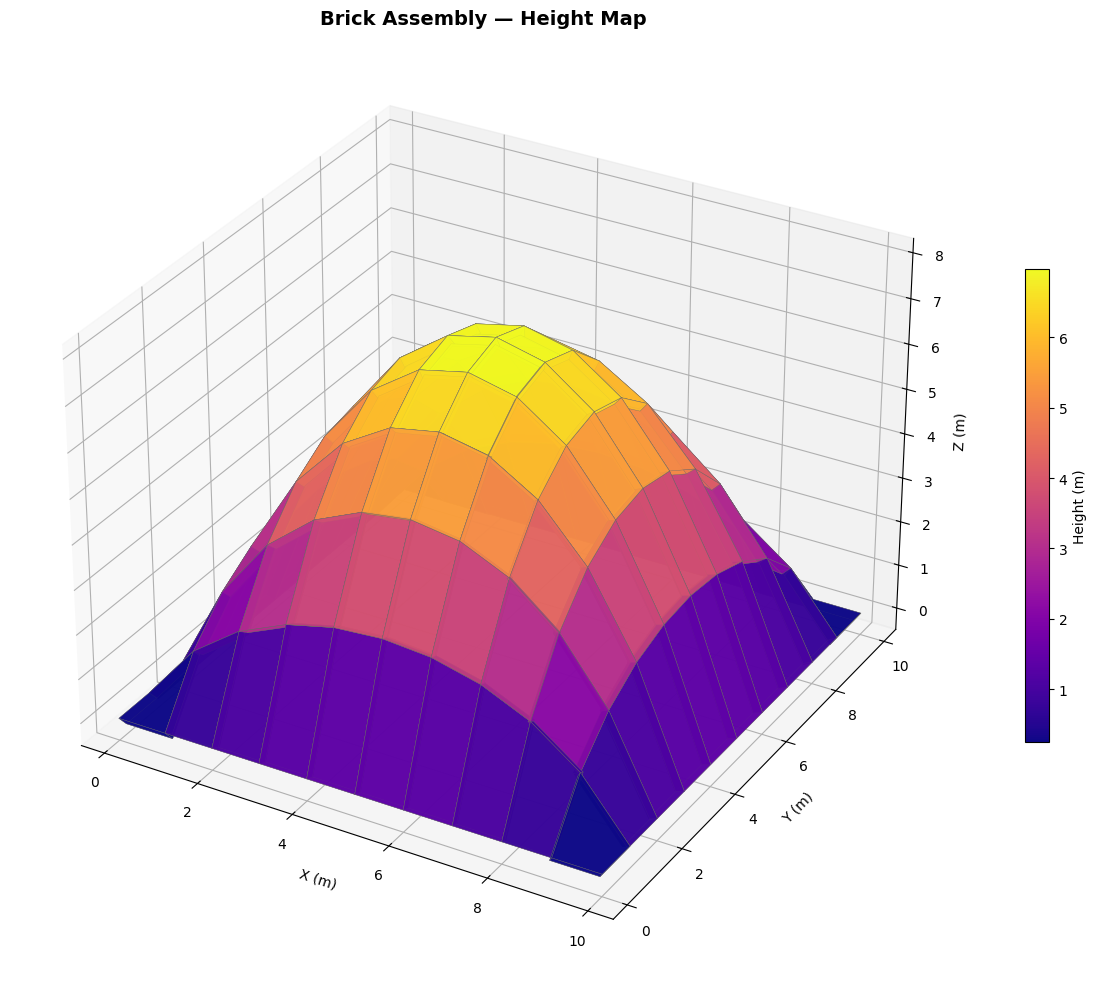

In [7]:
plot_bricks(assembly, title='Brick Assembly — Height Map',
            color_by='height', cmap='plasma')
plt.tight_layout()
plt.show()

## Step 7: Vary Thickness

How does brick thickness affect the look? Thin shell (0.1m), standard (0.2m), and chunky (0.5m).

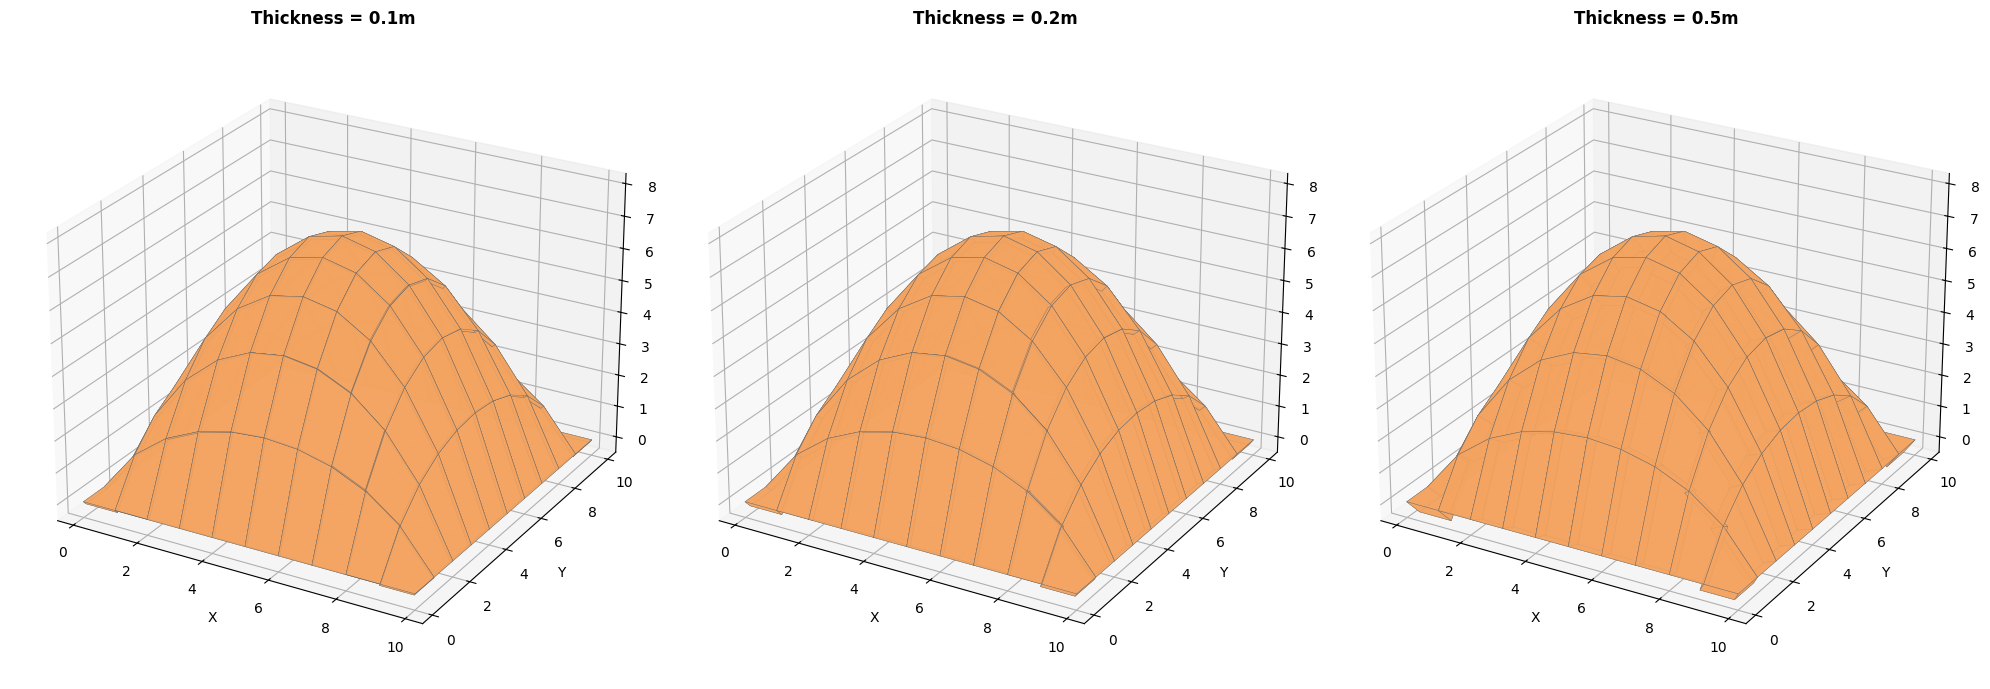

In [8]:
thicknesses = [0.1, 0.2, 0.5]
fig = plt.figure(figsize=(20, 7))

for idx, t in enumerate(thicknesses):
    a = voxelize(vault_xyz, mesh, thickness=t)
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')

    all_polys = []
    for i in range(len(a)):
        for f in brick_faces(a.corners[i]):
            all_polys.append(f)

    poly = Poly3DCollection(all_polys, alpha=0.85, facecolor='sandybrown',
                            edgecolor='dimgray', linewidth=0.3)
    ax.add_collection3d(poly)
    ax.set_xlim(-0.5, 10.5); ax.set_ylim(-0.5, 10.5)
    ax.set_zlim(-0.5, vault_xyz[:, 2].max() + 1)
    ax.set_title(f'Thickness = {t}m', fontweight='bold')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

## Step 8: Higher Resolution

More faces = more bricks = finer detail. Let's try a 25×25 mesh.

High-res: 625 bricks (625 faces)
Peak height: 45.86 m


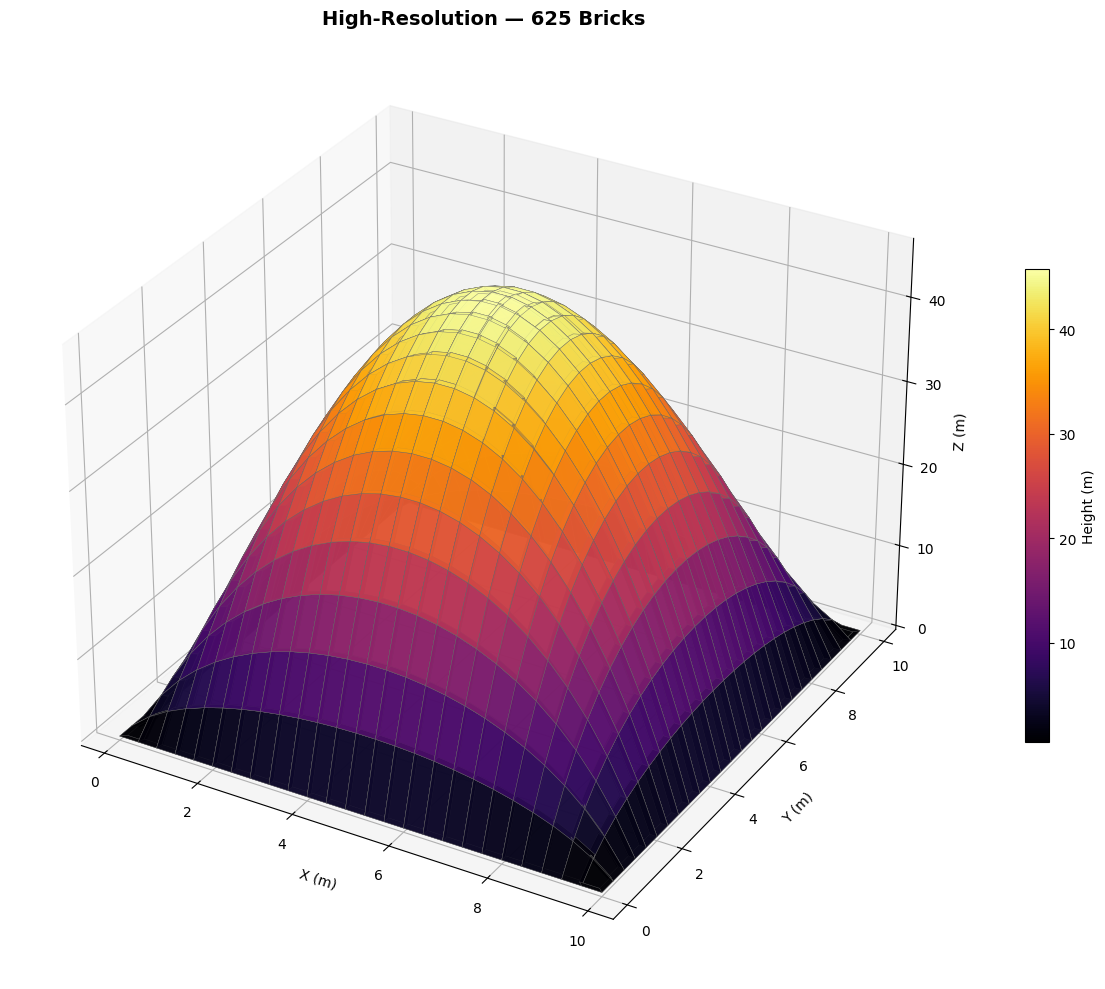

In [9]:
mesh_hr = Mesh.from_meshgrid(dx=10.0, nx=25)
verts_hr = mesh_hr.vertices_attributes('xyz')
edges_hr = list(mesh_hr.edges())
fixed_hr = list(mesh_hr.vertices_on_boundary())
loads_hr = [[0.0, 0.0, -1.0] for _ in verts_hr]
fds_hr = [1.0] * len(edges_hr)

res_hr = fd_numpy(
    vertices=verts_hr, fixed=fixed_hr, edges=edges_hr,
    forcedensities=fds_hr, loads=loads_hr,
)
hr_xyz = res_hr.vertices.copy()
hr_xyz[:, 2] = -hr_xyz[:, 2]

assembly_hr = voxelize(hr_xyz, mesh_hr, thickness=0.15)

print(f"High-res: {len(assembly_hr)} bricks ({mesh_hr.number_of_faces()} faces)")
print(f"Peak height: {hr_xyz[:, 2].max():.2f} m")

plot_bricks(assembly_hr, title=f'High-Resolution — {len(assembly_hr)} Bricks',
            color_by='height', cmap='inferno')
plt.tight_layout()
plt.show()

## Verification Summary

In [10]:
print("=== Verification ===")
print()

# 1. Brick count == face count
print(f"1. Brick count == face count: {len(assembly) == mesh.number_of_faces()}")

# 2. Normals are unit vectors
norms = np.linalg.norm(assembly.normals, axis=1)
print(f"2. Normals are unit vectors: {np.allclose(norms, 1.0)}")
print(f"   (min={norms.min():.6f}, max={norms.max():.6f})")

# 3. Neighbor relationships are symmetric
sym = all(
    i in assembly.neighbors[j]
    for i, nbs in enumerate(assembly.neighbors)
    for j in nbs
)
print(f"3. Neighbor relationships symmetric: {sym}")

# 4. Inner face vertices are exactly thickness away from outer face
all_diffs = np.linalg.norm(
    assembly.corners[:, :4] - assembly.corners[:, 4:8], axis=2
)
print(f"4. Inner-outer distance == thickness: {np.allclose(all_diffs, assembly.thickness)}")
print(f"   (min={all_diffs.min():.6f}, max={all_diffs.max():.6f}, target={assembly.thickness})")

print()
print("All checks passed!" if all([
    len(assembly) == mesh.number_of_faces(),
    np.allclose(norms, 1.0),
    sym,
    np.allclose(all_diffs, assembly.thickness),
]) else "Some checks FAILED")

=== Verification ===

1. Brick count == face count: True
2. Normals are unit vectors: True
   (min=1.000000, max=1.000000)
3. Neighbor relationships symmetric: True
4. Inner-outer distance == thickness: True
   (min=0.200000, max=0.200000, target=0.2)

All checks passed!


## What's Next

We now have a discrete brick assembly — each face of the vault mesh is a volumetric brick with known position, orientation, and neighbors.

**Next:** Construction sequencing (v0.3). A robot needs to know which brick to place first. Each brick must be self-supporting at the moment it's placed. `compas_cra` will analyze rigid block stability to find a valid build order.